In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from matplotlib import pyplot as plt
data_path='./Data/Macro/processed_macro_monthly.csv'

## 数据导入

In [3]:
macro_df=pd.read_csv(data_path,index_col=0)
print(macro_df.shape)
data_dim=macro_df.shape[0]
macro_df

(46, 200)


,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,...,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08
20230830-Au_Cu(COMEX),244.5900,259.432000,224.254545,194.917143,194.621111,194.642381,185.712273,201.813478,208.9020,214.830000,...,473.454545,473.372727,463.900625,457.040500,476.719565,503.006316,533.989000,515.211000,508.765714,515.840909
20230830-CEM(yoy),16.2600,11.255333,31.630000,14.409524,3.261111,14.500000,20.427273,14.565217,11.6000,13.272222,...,0.972727,0.400000,-5.175000,-12.300000,-12.300000,-12.300000,6.815000,1.310000,-0.452381,-1.500000
20230830-CPI(food-yoy),5.3900,5.866667,5.681818,7.214286,7.266667,7.957143,10.481818,14.152174,17.5000,17.405556,...,7.572727,4.750000,4.181250,5.500000,3.695652,2.442105,1.100000,0.790000,1.990476,-0.427273
20230830-CPI(mom),1.0150,1.166667,0.904545,0.071429,-0.155556,0.185714,0.372727,0.747826,1.1250,0.650000,...,0.163636,-0.104545,-0.112500,0.400000,-0.104348,-0.342105,-0.170000,-0.165000,-0.200000,0.072727
20230830-CPI(non-food-yoy),1.0650,0.966667,0.904545,1.071429,1.027778,1.000000,1.000000,0.930435,0.9000,1.022222,...,1.227273,1.100000,1.100000,1.150000,0.782609,0.363158,0.170000,0.035000,-0.457143,-0.267614
20230830-CPI(yoy),2.4845,2.596667,2.538182,3.117143,3.099444,3.287143,4.095455,5.236522,6.2950,6.348889,...,2.322727,1.759091,1.687500,1.950000,1.334783,0.763158,0.310000,0.165000,0.047619,-0.204545
20230830-CRB-IND,440.2095,440.616000,457.632273,474.520952,486.469444,493.893810,502.112727,495.153043,499.1960,512.900000,...,563.828182,570.799545,576.711875,569.702000,559.846522,560.276316,551.097000,550.204000,556.734762,556.189545
20230830-CRB-metal,707.1355,718.031333,783.032727,839.686190,875.660556,885.420952,911.627273,918.423478,911.2655,964.122222,...,960.161818,1010.453636,1081.142500,1087.543000,1066.835217,1064.203684,1006.660000,999.973500,1008.779048,994.985455
20230830-DBI,4464.2000,4389.400000,5123.136364,5732.571429,6419.166667,5772.142857,6581.227273,7198.652174,8574.0500,10671.333333,...,1298.954545,1467.409091,973.000000,658.350000,1410.043478,1486.368421,1397.050000,1067.150000,1040.190476,1149.590909
20230830-Electricity(yoy),14.6950,15.447333,27.310000,5.700000,13.794444,15.400000,16.045455,16.934783,15.5000,15.027778,...,0.178409,1.300000,0.253125,3.000000,3.000000,3.000000,5.159500,6.075000,5.467619,2.820000


## 数据加载

In [5]:
class MyDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len
     #由于是时序数据，因此总长度应该要减去时序长度

    def __getitem__(self, idx):
        # idx is the starting index of the sequence
        sample = self.data[idx:idx + self.seq_len + 1, :]
        # The last element is the target embedding
        return torch.tensor(sample[:-1, :]), torch.tensor(sample[-1, :])

## 模型声明

In [6]:
class MyDecoderLayer(nn.Module):
    def __init__(self, hidden_size, num_heads=1):
        super(MyDecoderLayer, self).__init__()

        self.self_attention = nn.MultiheadAttention(hidden_size, num_heads)
        self.feedforward = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.activation = nn.Tanh()

    def forward(self, x):
        x=self.activation(x)
        # 带掩码的自注意力机制
        attn_output, _ = self.self_attention(x, x, x, attn_mask=self.generate_mask(x.size(0)))
        # 残差链接
        x = x + attn_output
        x = self.norm1(x)
        # 前馈神经网络
        ff_output = self.feedforward(x)
        # 残差链接
        x = x + ff_output
        x = self.norm2(x)
        return x

    def generate_mask(self, size):
        # 生成上三角掩码
        mask = torch.triu(torch.ones(size, size), diagonal=1).to(device)
        return mask
    
class MyTransformerDecoder(nn.Module):
    def __init__(self,input_size, hidden_size,  num_layers=1,num_heads=1):
        super(MyTransformerDecoder, self).__init__()
        self.product_layer=nn.Linear(input_size,hidden_size)
        self.layer_stack= nn.ModuleList([MyDecoderLayer(hidden_size,num_heads) for _ in range(num_layers)])
        # 线性映射
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        x=self.product_layer(x) # batch ……  seq_len …… embeddingsize
       
        x = x.permute(1, 0, 2) # seq_len ……  batch ……  embeddingsize

        for layer in self.layer_stack:
            x = layer(x)
        # print(x.shape)
        out = self.fc(x[-1, :, :])  # 仅使用序列的最后一个时间步的输出
        return out

In [7]:
# 数据处理和嵌入层
class DataEmbedding(nn.Module):
    def __init__(self, data_dim, embedding_size):
        super(DataEmbedding, self).__init__()

        # Embedding layer for each indicator
        self.embeddings = nn.Linear(data_dim, embedding_size) 
        self.activation = nn.Tanh()

    def forward(self, x):
        # x shape: (Batch_size, Seq_len-1, Num_indicators)
        # print('embedding  ',x.shape)
        x_embedded=self.embeddings(x)
        return x_embedded# 这里相当于将宏观数据的embedding生成完毕  batch …… seq_len …… embeddingsize

## 模型的参数

In [8]:
# 数据和模型参数
num_indicators = macro_df.shape[0]
embedding_size = 128
seq_len = 10
hidden_size = 128
num_layers = 2
num_heads = 4
batch_size = 64
num_epochs = 10

# 模型、数据、优化器和损失函数
embedding_layer = DataEmbedding(num_indicators, embedding_size).to(device)
model = MyTransformerDecoder(embedding_size, hidden_size, num_layers, num_heads).to(device)
criterion = nn.MSELoss()
all_parameters = list(model.parameters()) + list(embedding_layer.parameters()) #将两个模型的参数合并
optimizer = torch.optim.Adam(all_parameters, lr=0.01)

In [10]:
# 获取列的数量
num_columns = len(macro_df.columns)
# 按照 1:4 的比例划分列
split_ratio = 0.9  # 测试集占比
num_test_columns = int(num_columns * split_ratio)
# 选择用于测试的列
train_columns = macro_df.columns[:num_test_columns]
# 选择用于训练的列
test_columns = macro_df.columns[num_test_columns:]
# 根据划分的列获取训练集和测试集
train_df = macro_df[train_columns]
test_df = macro_df[test_columns]

train_dataset = MyDataset(train_df.values.T, seq_len) # shape: (Num_months, Num_indicators)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

test_dataset = MyDataset(test_df.values.T, seq_len) #shape: (Num_months, Num_indicators)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
len(test_dataloader),len(train_dataloader)

## 训练

In [11]:
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for input_data, target in train_dataloader:    
        # print(input_data.shape)
        input_data = input_data.to(device).to(dtype=torch.float32) # (Batch_size, Seq_len, Num_indicators)
        target = target.to(device).to(dtype=torch.float32) # Batch_size, Num_indicators

        optimizer.zero_grad()
        # 数据嵌入
        data = embedding_layer(torch.cat((input_data, target.unsqueeze(1)), dim=1))   # batchsize …… seq_len+1 …… embeddingsize
        data=torch.tanh(data)
        input_data,target_data=data[:,:-1,:],data[:,-1,:] # batchsize …… seq_len …… num_ind*embeddingsize  #  batchsize  …… embeddingsize
        # print("target",target_data.shape)
        # print("input",input_data.shape)

        # 模型前向传播
        output = model(input_data)  # batchsize  …… num_ind*embeddingsize
        # print("output",output.shape)
        # 计算损失
        loss = criterion(output, target_data) # 令两者尽可能的相似
        total_train_loss += loss.item()
        # 反向传播和优化
        loss.backward()
        optimizer.step()

    # 打印训练信息
    
    model.eval()
    with torch.no_grad():
        total_loss = 0.0

        for input_data, target in test_dataloader:
            input_data = input_data.to(device).to(dtype=torch.float32) # (Batch_size, Seq_len, Num_indicators)
            target = target.to(device).to(dtype=torch.float32) # Batch_size, Num_indicators\

            data = embedding_layer(torch.cat((input_data, target.unsqueeze(1)), dim=1))   # batchsize …… seq_len+1 …… embeddingsize
            data=torch.tanh(data)
            input_data,target_data=data[:,:-1,:],data[:,-1,:] # batchsize …… seq_len …… num_ind*embeddingsize  #  batchsize  …… num_ind*embeddingsize

            # 模型前向传播
            outputs = model(input_data)  # batchsize  …… embeddingsize

            # 计算损失
            loss = criterion(outputs, target_data)
            total_loss += loss.item()

        # 计算训练集和测试集上的平均损失和准确率
        average_train_loss = total_train_loss / len(train_dataloader)
        average_loss = total_loss / len(test_dataloader)
        train_losses.append(average_train_loss)
        test_losses.append(average_loss)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Train loss: {average_train_loss}, Test Loss: {average_loss:.4f},') if (epoch+1) % 1== 0 else None

Epoch 1/10, Train loss: 0.9029896457990011, Test Loss: 0.2619,
Epoch 2/10, Train loss: 0.2618298331896464, Test Loss: 0.1147,
Epoch 3/10, Train loss: 0.148792694012324, Test Loss: 0.0583,
Epoch 4/10, Train loss: 0.09144918868939082, Test Loss: 0.0566,
Epoch 5/10, Train loss: 0.06922639037172, Test Loss: 0.0314,
Epoch 6/10, Train loss: 0.05055628592769305, Test Loss: 0.0180,
Epoch 7/10, Train loss: 0.03842846925059954, Test Loss: 0.0191,
Epoch 8/10, Train loss: 0.03003601295252641, Test Loss: 0.0102,
Epoch 9/10, Train loss: 0.020596634596586227, Test Loss: 0.0082,
Epoch 10/10, Train loss: 0.016025935299694538, Test Loss: 0.0053,


## 绘制误差曲线

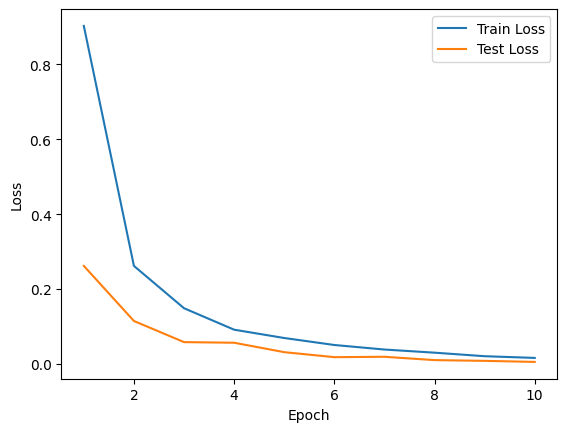

In [12]:

plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 保存模型

In [13]:
# 保存模型参数到文件
torch.save(embedding_layer.embeddings.state_dict(), 'embedding_params(linear).pth')

In [14]:
## 接下来使用只需要运行下面代码即可导入训练完的embedding
# 创建一个相同结构的 nn.Embedding 实例
embedding_layer = DataEmbedding(num_indicators, embedding_size).to(device)

# 加载保存的参数
embedding_layer.embeddings.load_state_dict(torch.load('embedding_params(linear).pth'))

<All keys matched successfully>

根据模型生成对应的embedding

In [15]:
macro_data=torch.tensor(macro_df.values.T).to(device).to(dtype=torch.float32)
macro_embedding=embedding_layer(macro_data)
macro_embedding=macro_embedding.to('cpu').detach().numpy()[1:]

In [16]:
for item in macro_embedding:
    print(item)

[ -477.37296    541.8059     134.75142    752.37823    457.46616
  -552.7273    -275.75742    591.14984   -362.91895   -707.1979
   333.11298    300.6443     440.28162    466.5327     846.02747
  -742.77405    757.0352     265.5119     654.69464    121.48533
   827.8919    -339.60043    466.33588    485.22617    167.37056
  -368.60568   -655.2675     349.6347    -292.06592    426.74713
   453.3565     512.5737     564.5801      88.57644   -523.68054
  -641.2881    -410.838     -200.94763   -727.32794   -519.5847
  -236.59901  -1004.1017    -170.90614    165.10765   -350.04343
   532.0502    -610.1668     623.0823     286.82224    477.07764
   722.00885    451.56128    115.02576    368.22       434.22452
  -485.7293    -680.79425   -168.95436    620.8586    -547.4371
  -187.67079    667.0286    -384.2516    -616.3671     518.5005
   496.3421    -424.12027   -461.67007   -965.6262    -406.25134
  1020.4129      14.529931   699.75507   -704.78546   -156.99702
   264.8602    -103.53693    

In [17]:
np.save('./Data/Macro/macro_embedding.npy', macro_embedding)

: 

In [54]:
tem=np.load('./Data/Macro/macro_embedding.npy')